# Basics of Kikuchi Pattern Processing

**Initialization code**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import Image, display 

import skimage
import skimage.io

# aloe routines 
from aloe.jutils import show_source
from aloe.plots import plot_image
from aloe.image.kikufilter import make_signal_bg_fft, remove_bg_fft
from aloe.image.kikufilter import img_to_uint
from aloe.image.downsample import downsample
from aloe.image.kikufilter import process_ebsp

## Motivation

* data acquisition
* data preparation / filtering / cleaning

Electrons scattered from the sample in an SEM carry crystallographic and other information which is conveyed in the intensity distribution measured on a two-dimensional electron detector, the electron backscatter pattern (EBSP). 
Useful information is distributed in the EBSP on different spatial and intensity scales, i.e. we often observe a relatively low-intensity signal varying over a few pixels (the Kikuchi diffraction signal) superimposed on a relatively large, dominating "background" signal that varies slowly on the scale of the detector dimensions (large spatial dimension). 

For pure image processing purposes, we can artificially partition the as measured EBSP as the sum of a Kikuchi signal and the background signal, acted on by a DETECTOR_RESPONSE function:

EBSP = DETECTOR_RESPONSE @ (KIKUCHI + BACKGROUND)  

The camera electronics has to be able to capture the large intensity variation from the edges to the middle of the image. 
At the same time, the camera also has to sufficiently resolve the remaining small signal variations in the small, a-few-pixel-sized regions where the Kikuchi bands and lines are observed, which we aim to extract in for the subsequent crystallographic analysis.

EBSP pattern processing serves the purpose to process the measured raw pattern data in such a way that the crystallographic information stored in the Kikuchi diffraction pattern can be extracted in the fastest way by the subsequent "indexing" steps.

Beyond the mere extraction of the crystallographic orientation from the Kikuchi pattern, it would also be desirable to define a specific data processing pipeline which helps to extract meaningful data on the physical processes that govern the signal formation and thus extract additional information about the sample scattering the electrons. This aim can be reached only partially, i.e. the clear separation of image processing and extraction of physical process data is not always possible.
This concerns questions such as the details of the energy and momentum distribution and trajectories of electrons scattered inside the sample. These can be assumed to be different for those electrons that form the Kikuchi diffraction patterns vs. the "background" electrons.

The aim of the image processing of the raw EBSD patterns is to extract the information which is necessary as input for the next data analysis steps. Mainly, this concerns the extraction of the diffraction information, but we can also be interested in the angle-dependent backscattered intensity independent of any diffraction effects.

In dependence on the requirements of the subsequent processing steps, the image processing needs to conserve detail to different extents. 

80x60:
For example, the line detection via the Hough/Radon transforms will benefit from a different image processing compared to quantitative pattern matching using simulated patterns based on electron diffraction physics.
The most important aspect for the HT approach is to be able to detect any possible Kikuchi bands which are present, even in  rather noisy raw data, and to do this with the highest speed possible in oder to make high indexing rates possible.
As long as the band detection works reliably, we can live with noisy data, which would be otherwise of insufficient quality for a quantitative analyis.
This is also true for pattern matching approaches for low-resolution orientation determination, which can be stable against even noisier data than the Hough transform approach.

800x600:
In comparison, the image processing pipeline for a pattern matching approach for phase identification or high-resolution orientation measurements has to ensure that the quantitive physical information, which we describe by the theoretical simulation model, will not result in distorted or biased data after the image processing procedure. We have to be able to describe the effects of the image data processing relative to the image model based on scattering physics of electrons in the sample.

The quantitative image matching relies on fine details for which the Hough transformation is at best insensitive or in the worst case even negatively influenced (e.g. if beyond an optimum value, pattern resolutions can actually be too high for the Hough transform, because highly resolved patterns can produce additional peaks in the Hough transform which can confuse a peak detection algorithm.)

#### Example 1: Pattern matching for advanced phase analysis and high-precision orientation determination

Below, we compare a processed, low-noise experimental Kikuchi pattern form a silicon sample (800x600, top) with a simulation using the dynamical theory of electron diffraction (middle) and their difference (bottom). The experimental pattern was measured at 15kV acceleration voltage, the simulated pattern fits best if we assume a mean energy of about 14keV for the backscattered electrons which contribute specifically to the Kikuchi pattern. The value of the normalized cross correlation coeffcient $r=0.768$ indicates a very good fit between experiment and simulation. The patterns have been normalized to a mean value of $\mu=0.0$ and a standard deviation $\sigma=1.0$ for consistent comparison between experiment and simulation. The difference plot in the bottom panel shows that (compared to the simulation) the bands in the experimental pattern have slightly higher intensity (red) on their top side than on the bottom side (blue). This specific difference between experiment and simulation is related to the so-called "excess-deficiency effect", which is not treated in the simplified simulation shown here.

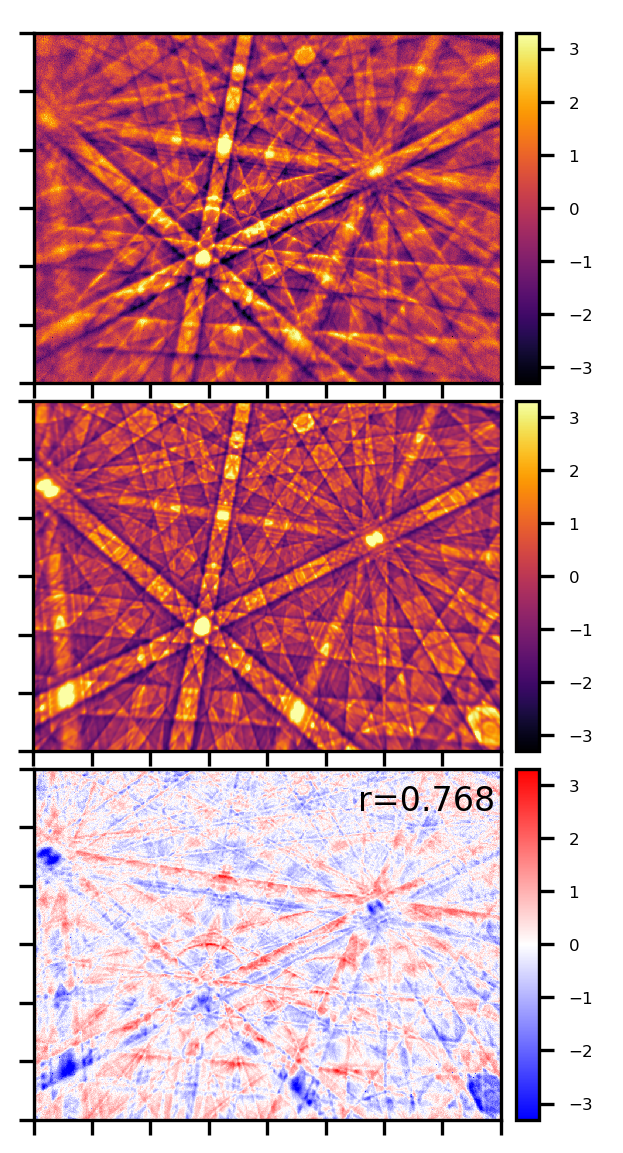

In [2]:
display(Image(filename="./data/Si/Si_ROI_0_E_14000_W500_B1.5.png", width=500))

#### Example 2: Line detection for fast indexing

Below we show an example pattern from a conventional EBSD indexing approach.
The final indexing lines are displayed on the (noisy) Kikuchi signal in the original measured resolution, which is 320x240. The signal-to-noise ratio is suffcient for fast orientation measurements.
Internally, the Hough transform line detection and subsequent indexing algorithms use binned and binarized images, i.e. at 80x60 pixels, which is shown at the bottom.

The use of the binned data in the indexing stage suggests that the resolution of the Hough transform line detection process can limit the resolution of the orientation determination, and not necessarily the resolution of the measured EBSD patterns. 
In this way, increasing the resolution of your measured EBSD pattern does not always improve the orientation data!

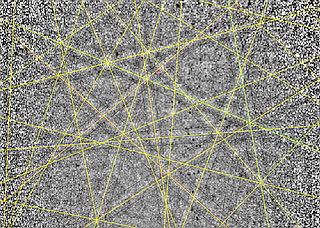

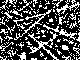

In [3]:
display(Image(filename='./data/ocean_116_176_indexed.png'))
display(Image(filename='./data/ocean_116_176_binary.png'))

## Image Processing

In an 8bit pattern, we have available a range of 256 grey values from 0 to 255 which can be adjusted by setting the gain and offset of the camera: the offset determines the pixel values with 0 intensity, and the gain allows to scale the intensity so that the highest intensity values are at 255.

The full dynamic range is often not filled in each pattern of a map, because the total BSE signal itself can vary at different places in the map, e.g. different phases can have different backscattering coefficients. In order to capture these variations, some patterns might have too little intensity for the full range in weakly backscattering phases in the map, while others have a range of intensity values that fits the full range of available channels in strongly backscattering regions. Also, the range of the noise needs to be considered.

We see that the camera parameters have to be set to match the signal variations which are present (a) inside a pattern and (b) inside a map. As this is not perfectly possible at all times, compromises have to be made, underexposing patterns in some regions and overexposing the patterns in others. A 16bit camera providing 2^16 gray levels might help if the dynamic range of the sample (map and patterns) is too high to be efficiently captured in an 8bit setup. Note that many cameras can only 12bit dynamic range, so although the image format might use 16bit, these might not be actually fully used by the camera.

#### Low noise  patterns for HR work

This is an average pattern of 10 patterns from a single grain, saved as ASCII text floating point numbers. 
The imported data will have 64bit floating point resolution in memory; note that importing this e.g. as 8bit integers (np.uint8) would reduce the intensity resolution available by the pattern averaging (the same applies escpecially for the static background pattern, see below).

float64


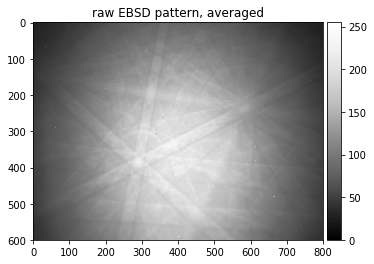

In [4]:
raw_pattern = np.loadtxt("./data/Si/Si_15000_10_rot.dat")
raw_pattern = 255 * raw_pattern/np.max(raw_pattern)
print(raw_pattern.dtype)
plot_image(raw_pattern, [0,255], title='raw EBSD pattern, averaged')

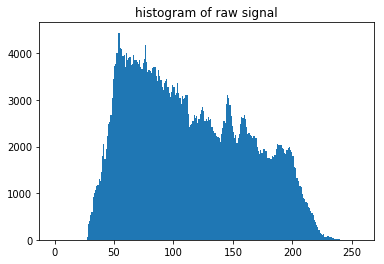

In [5]:
n, bins, patches = plt.hist(np.ravel(raw_pattern), 256, range=[0,256])
plt.title('histogram of raw signal')
plt.show()

In [6]:
print('pattern height, width: ', raw_pattern.shape)
print('maximum grey value in image: ', np.max(raw_pattern))
print('minimum grey value in image: ', np.min(raw_pattern))
print(raw_pattern)

pattern height, width:  (600, 800)
maximum grey value in image:  255.0
minimum grey value in image:  27.2055352055
[[ 29.45421245  29.57875458  29.44037444 ...,  29.01139601  28.99063899
   29.21204721]
 [ 29.48188848  29.33658934  29.03907204 ...,  29.19129019  28.92144892
   29.3019943 ]
 [ 29.34350834  29.52340252  29.48880749 ...,  29.7032967   29.20512821
   29.24664225]
 ..., 
 [ 40.60765161  39.86039886  40.22018722 ...,  39.07855108  38.47659748
   39.12006512]
 [ 40.06796907  40.16483516  40.44851445 ...,  38.93325193  38.72568173
   39.02319902]
 [ 40.89133089  40.53846154  40.4969475  ...,  39.45909646  38.78795279
   38.75335775]]


### Deciphering the Pattern Information

The approach of the "dynamic" background correction is to to filter each pattern seperately without any additional data needed.
Note that "dynamic" refers to this pattern-individual approach and is not related to the "dynamical simulations" of Kikuchi patterns. 

A simple approach to obtain only the large scale variations (i.e. within a scale of many pixels) is to apply a Fourier transform filter that keeps only the low frequency components (low pass filter). The "filterfft" routines in the "BGK" function is accomplishing this low-pass FFT filter:

For pattern processing by [fast Fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) (FFT) filtering, we will use the "filterfft" routines, developed originally by Connelly Barnes http://www.connellybarnes.com/work/, with the code available at http://www.connellybarnes.com/code/python/filterfft :

In [7]:
show_source(make_signal_bg_fft)

600


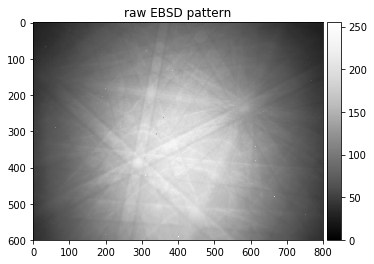

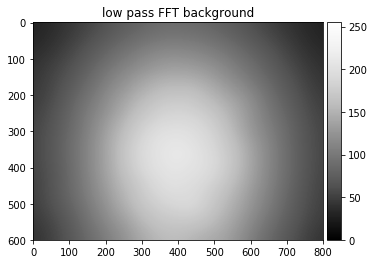

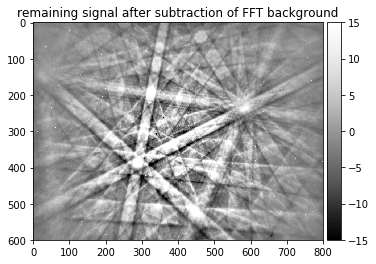

In [8]:
#raw_pattern=raw_pattern1
print(raw_pattern.shape[0])
raw_pattern_signal, raw_pattern_bg = make_signal_bg_fft(raw_pattern, sigma = 40)

plot_image(raw_pattern, [0,255], title='raw EBSD pattern')
plot_image(raw_pattern_bg, [0,255], title='low pass FFT background')
plot_image(raw_pattern_signal, [-15,15], title='remaining signal after subtraction of FFT background')


Unfortunately, we see that while we empasize the Kikuchi diffraction signal, there are some disturbing features remaining.
In this example, we see "hot pixels" that always give a high signal (white pixels). 

To remove those effects which are constant, we can divide them out by taking a reference image with low noise and without any diffraction features. This is called *Static Background* correction.

### The Static Background

(600, 800)


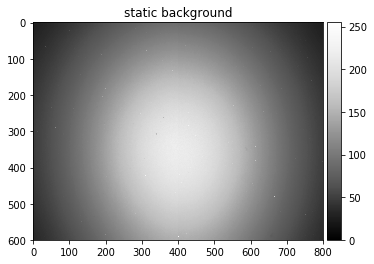

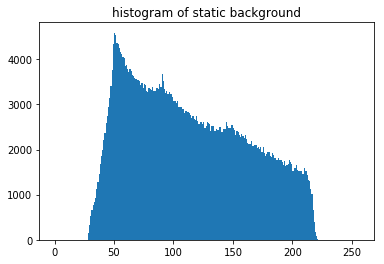

In [9]:
static_bg=np.loadtxt('./data/Si/Al_StaticBackground_BAM.dat')
static_bg = 255 * static_bg/np.max(static_bg)
print(static_bg.shape)
plot_image(static_bg, [0,255], title='static background')

# histogram
n, bins, patches = plt.hist(np.ravel(static_bg), 256, range=[0,256])
plt.title('histogram of static background')
plt.show()

In order to see the different contributions to the experimental static background, we can deconstruct it into a smooth part by FFT filtering (just like for the dynamic background correction) and a small scale part. 

We can discern different contributions to the detector response, which can be attributed to the phosphor screen (dark spots caused by dust), and to the CCD chip used for capturing the image from the phosphor screen. The CCD chip is combined out of two halves, which can have a slightly different response. In addition there are "hot pixels" of high intensity, vertical lines (thermal curtaining). All of these effects are well known properties of CCD cameras which can be corrected for. 

If we assume that these detector contributions stay constant over time, i.e. they are contributing to the measured data in the same way, we can divide out the static contributions.

The large scale smooth intensity varaiations which are caused by the angular distribution of the backscattered electrons and the gnomonic projection effects on the detected solid angle per pixel are handled well by the dynamic background correction discussed next.

#### Properties of the static background

Independent of the method we have used to acquire a static background image, we should check this static background for any residual diffraction features and the remaining noise. As the magnitude of these effects might be hard to see in the static background data, we apply a dynamic background correction to the static background and partition the static background in a large scale and in a small scale varying part.

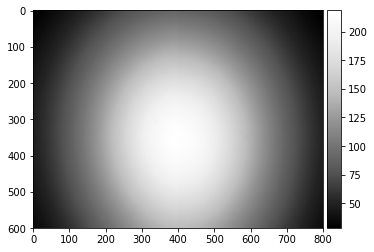

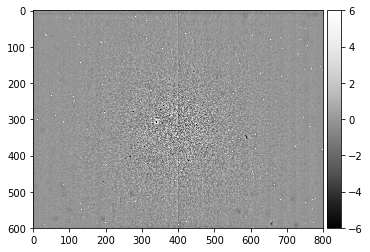

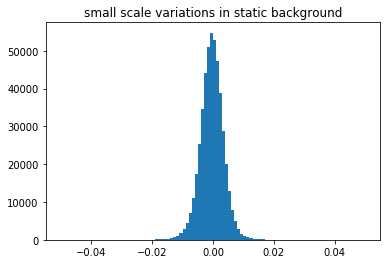

In [10]:
screen_static, static_bg_smooth = make_signal_bg_fft(static_bg, sigma = 5, bgscale=1.0)

plot_image(static_bg_smooth)
plot_image(screen_static,[-6,6])

small_scale_variations=screen_static/static_bg_smooth
n, bins, patches = plt.hist(np.ravel(small_scale_variations), 100, range=[-0.05,0.05])
plt.title('small scale variations in static background')
plt.show()

The fine details of the static background show the hot pixels seen previously, but we can also reveal black spots and smudges due to contamination on the phosphor screen. We also have electronic hardware effects of the camera (horizontal lines in the top region), we see two halves of the CCD chip, possibly exposed differently and divided by the central vertical line, as well as additional [banding noise](https://photo.stackexchange.com/questions/41874/what-causes-banding-noise) of the digital image sensor (the vertical stripes). 

If the black or white spots are very frequent, the histogram of the small scale variations will show asymmetries, with more values on the lower side corresponding to the dark spots formed by the contamination on the screen and the horizontal artefact in the top lines.

We can test that both contributions combined actually result in exactly the original static background saved.
In this way, we have a well-defined segmentation of the image data into a background and an additive signal.
If we combine both contributions and subtract them form the original data, we should obtain a zero difference image.
This can be tested by comparison of two arrays using the function `numpy.testing.assert_almost_equal`.

In [11]:
all_recombined = screen_static + static_bg_smooth
np.testing.assert_almost_equal(static_bg, all_recombined)

#### Examples of Detector Effects

Detector with severe contamination, a hardware problem for the top lines, different exposure in CCD halves, hot pixels, banding noise, and visible Kikuchi band features due to insufficient averaging when taking the static background:

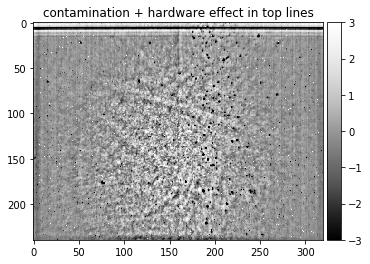

In [12]:
static_ocean = np.loadtxt("./data/static_ocean.dat")
plot_image(static_ocean, [-3,3], title = "contamination + hardware effect in top lines")

Detector with severely unbalanced exposure in the CCD halves, taken from the AstroEBSD example data set at https://zenodo.org/record/1214829 (due to the limited number of grains in the map, some Kikuchi features are still visible, illustrating the limited possibility to extract a static background afterwards if not enough grains with different orientations can be averaged):

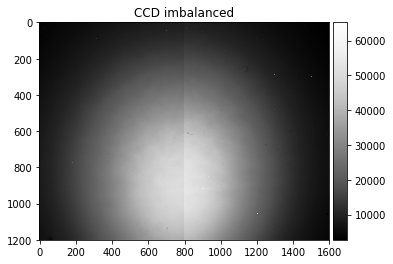

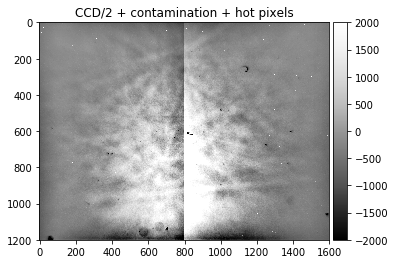

In [13]:
astro_map_average = np.loadtxt("./data/static_astro.dat")
static_astro, static_astro_smooth  =  make_signal_bg_fft(astro_map_average, sigma = 100, bgscale=1.0)
plot_image(astro_map_average, title= "CCD imbalanced")
plot_image(static_astro, [-2000,2000], title= "CCD/2 + contamination + hot pixels")

Phosphor Inhomogeneities:

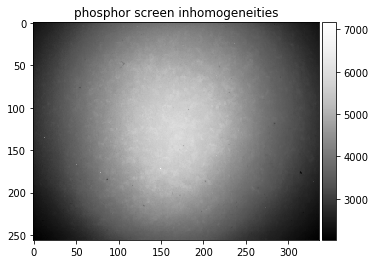

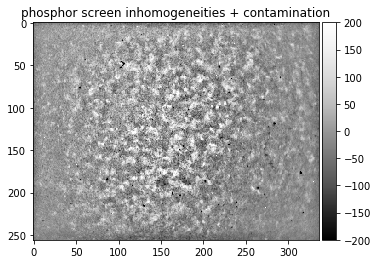

In [14]:
static_soup = np.loadtxt("./data/static_wedding_soup.dat")
static_fine, static_astro_smooth  =  make_signal_bg_fft(static_soup, sigma = 10, bgscale=1.0)
plot_image(static_soup, title= "phosphor screen inhomogeneities")
plot_image(static_fine, [-200,200], title= "phosphor screen inhomogeneities + contamination")

### The Dynamic Background

omit static background, live with detector response

i.e. post processing of raw data for which no static background was measured


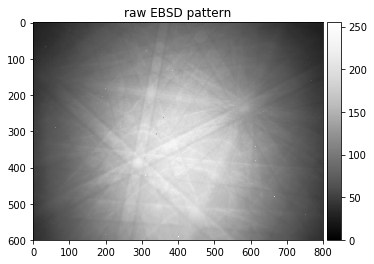

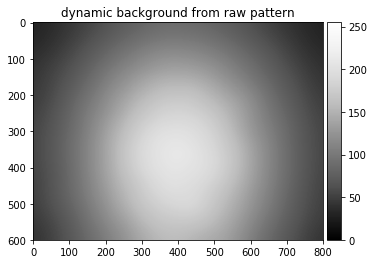

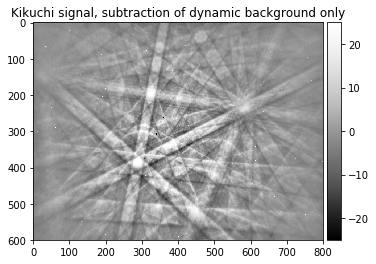

In [15]:
raw_pattern_signal, raw_pattern_bg=make_signal_bg_fft(raw_pattern, sigma=40, bgscale=1.0)
signal_relative=raw_pattern_signal/raw_pattern_bg

plot_image(raw_pattern, [0,255], title='raw EBSD pattern')
plot_image(raw_pattern_bg, [0,255], title='dynamic background from raw pattern')
plot_image(raw_pattern_signal, [-25,25], title='Kikuchi signal, subtraction of dynamic background only')

#### Pattern contamination after dynamic background correction

If only the dynamic background correction is used, the resulting pattern will still contain a contamination by detector features which have been "averaged away" by the filtering process (i.e. the small scale features of the static background image):

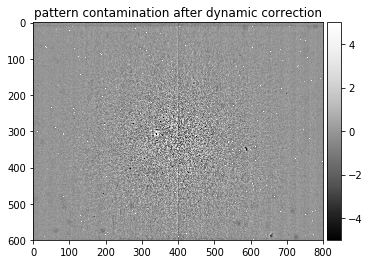

In [16]:
plot_image(screen_static,[-5,5], title='pattern contamination after dynamic correction')

We see that the detector response is present in addition to the actual Kikuchi pattern signal. In many cases, the indexing process can live with such data.

### Static Background Correction and Flat Fielding

#### Static Background Division

Imagine that you take a picture from a white piece of paper. You know that the paper is perfectly and uniformly white in reality. If you see any disturbing features in the final image data (maybe some pixels are darker than others; maybe some pixels show stange colors), you would assign these features to the optical and electronic system of your camera. If these effects are removed from your imperfect image, it should appear perfectly white again and give a correct representation of the physical reality.
In a digital camera, this correction process is largely hidden from the user, but you can easily imagine that different pixels on the image sensor can have slightly different sensitivities, or there could be dust on some pixels which also reduces the pixel signal.

In EBSD, we also need to remove the relative variations of the detector response in the image. We can achieve this by division of each single pattern by the same constant "static background". This procedure is also known in the contexts of digital imaging as [flat field correction](https://en.wikipedia.org/wiki/Flat-field_correction) with the aim to remove artifacts from 2D images due to the pixel-to-pixel sensitivity of the detector and other influences in the imaging system. 

After the correction for the detector response, we can handle the remaining large-scale intensity and angular variation from pattern to pattern individually for each pattern by a "dynamic background" correction.
Note that, ideally, the detector response could be taken with an almost constant intensity over the whole image by an even illumination of the phosphor. 

Experimentally, an average static background over a large sample area is often used for background correction. If the Kikuchi features are averaged out, the static background corrects for two different effects: (a) the detector contamination, dead pixels, hot pixels etc and (b) the average, smooth variation of the background signal. Note the difference between (a) and (b): (a) are the constant effects of the detector, (b) also changes the signal that we measure.

By background division we keep at least a relative size of the signal. Subtraction does not allow to conclude on the size of the background that was subtracted.

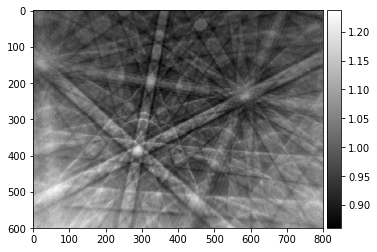

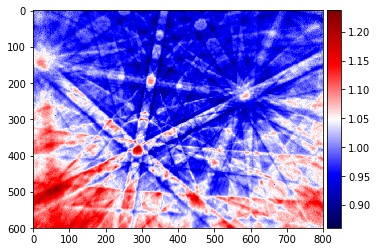

In [17]:
pattern_div=raw_pattern/static_bg
#pattern_div=screen_static
plot_image(pattern_div, cmap='gray')
plot_image(pattern_div, cmap='seismic')

#### Static Background Subtraction

In contrast to the division, the subtraction of the static background is problematic.

We do not know the correct absolue scale of the static signal, so simply subtracting it will not lead to a good signal, because either the background or the raw pattern will dominate the result, depending on which is larger.

We need to scale the static background to vary approximately in the same limits as the raw pattern. The necessary scaling factor will be related to the relative exposure times and signal sizes of the raw data and the background.
But note that this factor will in principle change from one pattern to the next, as different phases can produce more or less signal, with, in addition, a different angular distribution.

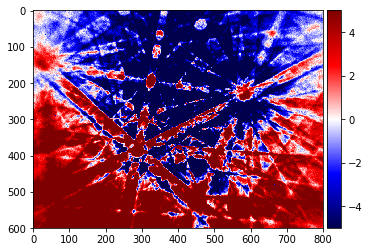

In [18]:
pattern_sub=raw_pattern-static_bg
plot_image(pattern_sub, [-5,5], cmap='seismic')

### Dynamic Background Correction

With the constant detector response corrected by the static background, we will now try to remove the remaining large-area variations which are larger than our Kikuchi band features which we want to emphasize as much as possible.
A possible approach is to use a Fourier transformation filter to suppress the image components which correspond to the large spatial extensions, which relate to low spatial frequencies, i.e. we need to do a high pass filter on the image.

#### Estimating the relative signal size in the raw uncorrected pattern data


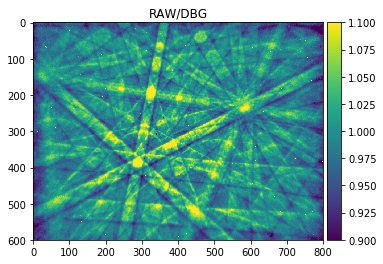

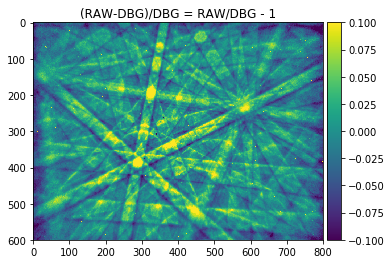

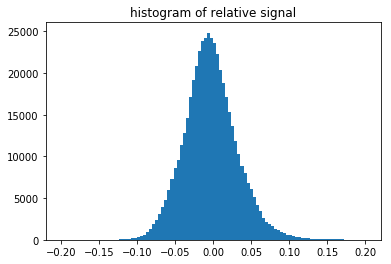

In [19]:
signal_amp = 0.1
plot_image(raw_pattern/raw_pattern_bg,  [1-signal_amp,1+signal_amp],cmap="viridis", title='RAW/DBG')
plot_image(signal_relative, [-signal_amp,+signal_amp], cmap="viridis", title='(RAW-DBG)/DBG = RAW/DBG - 1')

#plot_image(signal_relative, [-0.1,0.1], title='signal relative to dynamic background')

n, bins, patches = plt.hist(np.ravel(signal_relative), 100, range=[-2*signal_amp,+2*signal_amp])
plt.title('histogram of relative signal')
plt.show()

The histogram above shows the quantitative distribution of the relative signal. We see that the relative signal is within a few percent relative to the smooth background, e.g. the Kikuchi signal we aim to pick up is on the order of 10% of the background signal (this depends on the material an can range from a few percent to a maximum of about 20% as seen here for a single-crystal silicon sample).

The result for the purely dynamical background correction is first subtraction of the background and then divide to get the relative contribution.

#### Additonal dynamic background correction of the statically corrected pattern

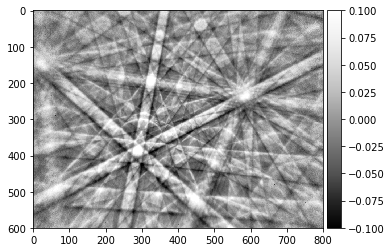

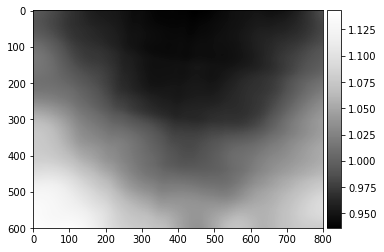

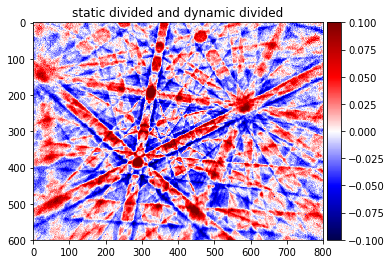

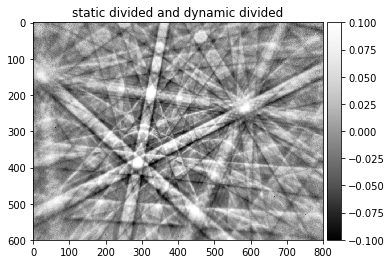

In [20]:
pattern_div_sub, pattern_div_bg = make_signal_bg_fft(pattern_div, sigma=50)

plot_image(pattern_div_sub,[-signal_amp,signal_amp])
plot_image(pattern_div_bg)


img_corrected=pattern_div_sub/pattern_div_bg
plot_image(img_corrected,[-signal_amp, signal_amp], cmap='seismic', title='static divided and dynamic divided')
plot_image(img_corrected,[-signal_amp, signal_amp], cmap='Greys_r', title='static divided and dynamic divided')
np.savetxt('./results/img_corrected.dat', img_corrected)

### Contrast stretching

http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

further image processing by routines optimzed for 8bit or 16bit integers

memory considerations compared to 32bit float values


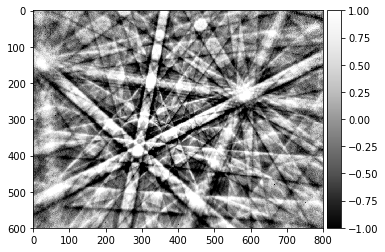

In [21]:
# get values at 3% and 97% frequency
p_low, p_high = np.percentile(img_corrected, (3, 97))

img_contrast_stretch = skimage.exposure.rescale_intensity(img_corrected, in_range=(p_low, p_high))
plot_image(img_contrast_stretch)

### Image Data Type Conversion

Computations on images can lead to arrays of floats with 32bit or even more, which can be memory consuming, slower to compute with and which cannot be directly saved into common image formats that can be viewed without additional tools. 

However, in many cases the data analysis is not limited by the floating point precision but by the dynamical range of the resulting signal. Often a range of 256 (8bits) or 65536 (16bits) integer values is sufficient to represent the data. 
This is why a rescaling and rounding of floating point data to 8 or 16 bit integer values can be useful as the final step of image processing, or even just for saving the image in 8bit formats like PNG or JPEG or 16bit TIFF formats.

The function "img_to_uint" in `aloe.image.kikufilter` can rescale a floating point array to 0..255 (or 65535), with 0 and 255/65535 at a certain contrast percentile. Setting these percentiles e.g. to 0.5 and 99.5 of all floating point pixel values, the lowest 0.5% and the highest 0.5% of the images will be scaled to "black (0)" and "white (255/65535)" respectively. 
This can reduce the influence of a few outliers with exceptionally high or low floating point values, because the outliers will be in the respective lower or higher precentages of floating point array.

In [22]:
show_source(img_to_uint)

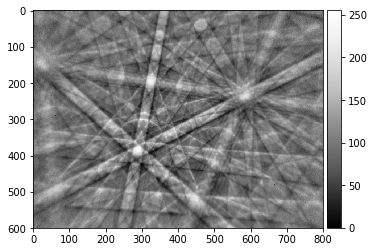

uint8


In [23]:
img8=img_to_uint(img_corrected, clow=0.001, chigh=99.999)
plot_image(img8)
print(img8.dtype)
skimage.io.imsave('./results/img_corrected_8bit.png', img8)

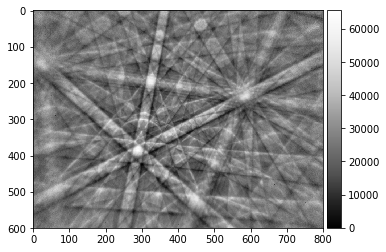

uint16


In [24]:
img16=img_to_uint(img_corrected, dtype=np.uint16, clow=0.001, chigh=99.999)
plot_image(img16)
print(img16.dtype)
# note: the eye cannot see 65000 grey levels...

To save a 16bit image in TIFF format, we can use skimage, which contains the [tifffile.py](https://www.lfd.uci.edu/~gohlke/code/tifffile.py.html) module from https://www.lfd.uci.edu/~gohlke/code/tifffile.py.html:

In [25]:
# check for available plugins
skimage.io.find_available_plugins()

{'fits': ['imread', 'imread_collection'],
 'gdal': ['imread', 'imread_collection'],
 'gtk': ['imshow'],
 'imageio': ['imread', 'imsave', 'imread_collection'],
 'imread': ['imread', 'imsave', 'imread_collection'],
 'matplotlib': ['imshow', 'imread', 'imshow_collection', 'imread_collection'],
 'pil': ['imread', 'imsave', 'imread_collection'],
 'qt': ['imshow', 'imsave', 'imread', 'imread_collection'],
 'simpleitk': ['imread', 'imsave', 'imread_collection'],
 'tifffile': ['imread', 'imsave', 'imread_collection']}

In [26]:
skimage.io.imsave('./results/img_corrected_16bit.tif', img16, plugin='tifffile')

#check that saved image gives the same data when loaded back  
im_saved = skimage.io.imread('./results/img_corrected_16bit.tif', plugin='tifffile')
print(im_saved.dtype)

np.testing.assert_array_equal(im_saved,img16)
#print(im_saved-img16)

uint16


#### Contrast Limited Adaptive Histogram Equalization (CLAHE)

http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist


* can change the intensity distribution considerably if not used properly
* intensity massage will affect agreement with simulations; use as mild image processing as possible
* might be better used for band detection, binarization


Note this will change the scaling of different regions in the image, so we have to be careful not to distort the relative intensity in the Kikuchi features. The kernel size should be larger than the Kikuchi features, as not to rescale the intensity  in the Kikuchi band profile. 

[15 20]
uint16
float64


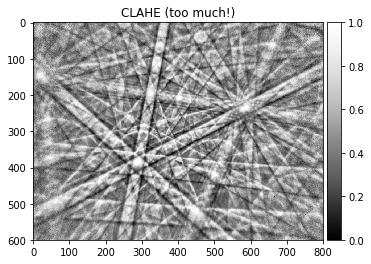

In [27]:
local_scale = 40 # divide image size by scale to get local kernel size, e.g. 1/10 of image dimensions
ksize=np.copy(img16.shape).astype(np.int) // local_scale
print(ksize)
img_adapteq = skimage.exposure.equalize_adapthist(img16, kernel_size=ksize, clip_limit=0.01, nbins=256)
print(img16.dtype)
print(img_adapteq.dtype)
plot_image(img_adapteq, title='CLAHE (too much!)')


img16_clahe=img_to_uint(img_adapteq, dtype=np.uint16, clow=0.001, chigh=99.999)
skimage.io.imsave('./results/img16_clahe.tif', img16_clahe, plugin='tifffile')

#toimage(img_adapteq).save('img_adapteq.png')

### Binning of Pattern Data 

* indexing: speed e.g. 80x60 internal image resolution

We use the [downsample](https://github.com/keflavich/image_tools/blob/master/image_tools/downsample.py) function from [Adam Ginsburg’s Python Code (agpy)](http://pythonhosted.org/agpy/image_tools.html) to combine the intensity values from several pixels. 

With a binning factor of 4, the intensity of groups of 4x4 pixels is combined into a single pixel. This means that an image of dimension (height=1024, width=1344) is reduced to a dimension of (256, 336). While the resolution of the image is reduced, the  noise (e.g. Poisson counting noise) will also be improved as more counts are assigned to a pixel.

Note that the binning will mean that the "center" of the 4x4 pixel region is the new center that is assigned to the measured intensity. This changes the angular calibration of the pixels ("pattern center").

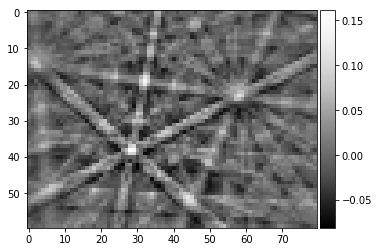

(60, 80)


In [28]:
binning=10
img_binned=downsample(img_corrected, binning)
plot_image(img_binned)

# save the binned down image:
#scipy.misc.toimage(img_binned, cmin=0.0, cmax=255).save('img_binned.png')
print(img_binned.shape)
#print(img_binned)

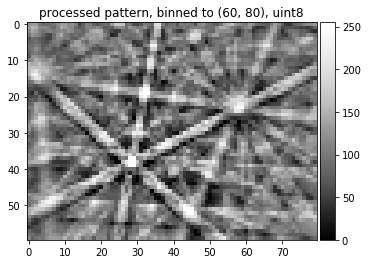

In [29]:
img8_binned=img_to_uint(img_binned)
plot_image(img8_binned, title='processed pattern, binned to '+str(img8_binned.shape)+', '+ str(img8_binned.dtype))
skimage.io.imsave('./results/img8_binned.tif', img8_binned, plugin='tifffile')

### Final Pipeline Function

We can combine the image processing steps discussed so far into a function, which can also be accessed in the kikufilter module: 

In [30]:
show_source(process_ebsp)

## Summary

The various steps discussed above have been used to implement a simple image processing pipeline which enables us to extract the Kikuchi diffraction information from the raw measured electron backscattering patterns (EBSP).

The basic steps are:

1. divide raw pattern by static background (without any Kikuchi features!) to remove detector contamination and hardware effects
2. correct the remaining large-scale intensity variations, e.g. by FFT filtering (= "dynamic background")
3. process pattern further depending on the application 

The binned and the unbinned pattern at the end of the filtering pipeline so far are preconditioned to be used for  subsequent application in:

* line detection and conventional indexing by the Hough or Radon transforms
* indexing by pattern matching from a pattern dictionary
* phase ID and orientation refinement from high resolution, low noise patterns, possibly starting from initial guess data obtained by the two previous approaches

The extraction of the Kikuchi patterns from the raw data now works by calling a single function (with sensible default parameters):

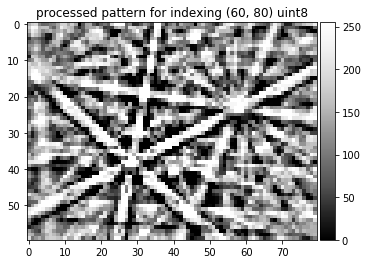

In [31]:
kikuchi_indexing=process_ebsp(raw_pattern, static_bg, dtype=np.uint8, 
                              binning=10, sigma=3, clow=10, chigh=90)

img=kikuchi_indexing
plot_image(img, title='processed pattern for indexing '+str(img.shape)+' '+ str(img.dtype))
skimage.io.imsave('./results/img_final_indexing_8bit.png', img)

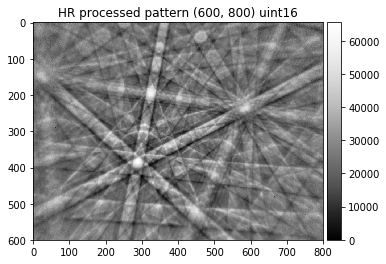

In [32]:
kikuchi_detailed=process_ebsp(raw_pattern, static_bg, dtype=np.uint16, sigma=40, 
                              clow=0.001, chigh=99.999)

img=kikuchi_detailed
plot_image(img, title='HR processed pattern '+str(img.shape)+' '+ str(img.dtype))
skimage.io.imsave('./results/img_final_detailed_16bit.tif', img, plugin='tifffile')